# Homework 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 3

In [2]:
#Draws n samples from the 1D pdf distribution pdf(t).
#pdf(t) can be an arbitrary pdf over 1 variable with lower bound low_t.
#pdf is defined over domain [0, T].
#resoution (i.e., step size) of prob_t is dt.
#Notes: should choose T and dt such that T >> dt, pdf(t > T) ~ 0.0, and low_t < T.
def pdf_samples(pdf, T, dt, n, low_t=0.0):
    if int(T / dt) == T / dt:
        t = np.arange(low_t, T + dt, dt)
    else:
        t = np.arange(low_t, T, dt)
    
    p = pdf(t)
    p = p / np.sum(p)
    
    return np.random.choice(t, n, p=p)

#polynomial fit of arrays (note: can't be lists) y to x
#deg is the polynomial degrees, e.g., if deg=[0, 1, 2], returns np.array(a, b, c)
#such that y(x) = a * x**0 + b * x**1 + c * x**2
def custom_regression(x, y, deg):
    matrix = np.stack([x**d for d in deg], axis=-1)   # stack them like columns
    coeff = np.linalg.lstsq(matrix, y)[0]    # lstsq returns some additional info we ignore

    return coeff

In [3]:
def poisson_times(t, tau):
    return (1.0 / tau) * np.exp(-t / tau)

#N = number of segments
#v = velocity
#tau = mean run time
#t_step = fundamental unit of time, mainly important for Brownian shakings. Should be significantly less than tau. 
def run_and_tumble(N, v, tau, rad, t_step=0.005, x_i=0.0, y_i=0.0, phi_i=0.0, temp=298.0, eta=8.9*10.0**-4.0):
    
    poisson_times_tau = lambda t: poisson_times(t, float(tau))
    
    k_B = 1.381 * 10.0**-23.0
    D_T = k_B * temp / (6.0 * np.pi * eta * rad)
    D_R = k_B * temp / (8.0 * np.pi * eta * rad**3.0)
    
    ### Divide full motion into discrete time steps.
    # All time steps involve translational and rotational diffusion, some time steps involve a tumble.
    
    run_lengths = pdf_samples(poisson_times_tau, tau * 10.0, t_step, N, low_t=t_step) # length of each run
    tumble_times = np.append(np.array([0.0]), run_lengths[:-1]) # times at which each tumble that starts a run occurs
    tumble_times = np.cumsum(tumble_times)
    all_times = np.arange(0.0, np.sum(run_lengths) + t_step, t_step) # all times considered.
    if all_times[-1] >  run_lengths[-1] + tumble_times[-1]:
        all_times = all_times[:-1]
    
    tumble_indices = np.where(np.in1d(all_times, tumble_times))[0] # indices of all_times where a tumble occurs
    
    ### Angles from tumbles
    
    temp = np.random.uniform(low=0.0, high=2.0*np.pi, size=len(tumble_indices))
    tumble_angles = np.zeros(len(all_times))
    tumble_angles[tumble_indices] = temp
    
    #Above, tumble_angles is an array like [1.0, 0.0, 0.0, 5.0, 0.0, 0.0, 2.3, ...]
    #Code below makes it like [1.0, 1.0, 1.0, 5.0, 5.0, 5.0, 2.3, ...]
    temp = np.arange(len(tumble_angles))
    temp[tumble_angles == 0.0] = 0.0
    temp = np.maximum.accumulate(temp)
    tumble_angles = tumble_angles[temp]

    ### Angles from rotational Brownian motion
    
    sigma_R = np.sqrt(2 * D_R * t_step)
    diffusion_angles = np.random.normal(scale=sigma_R, size=len(all_times))
    diffusion_angles[0] = phi_i
    diffusion_angles = np.cumsum(diffusion_angles)
    
    ### Movements from advection with angular diffusion
    
    angles = tumble_angles + diffusion_angles
    
    v_x_R = (v * np.cos(angles))
    v_y_R = (v * np.sin(angles))
    
    x_R = v_x_R * all_times
    x_R = np.cumsum(x_R)
    y_R = v_y_R * all_times
    y_R = np.cumsum(y_R)
        
    ### Movements from translational Brownian motion
    
    sigma_T = np.sqrt(2 * D_T * t_step)
    diffusion_translations = np.random.normal(scale=sigma_T, size=(len(all_times), 2))
    diffusion_translations[0] = np.zeros(2)
    
    x_T = diffusion_translations[:, 0]
    y_T = diffusion_translations[:, 1]
    
    ### Combining it all
    
    x_tot = x_R + x_T + x_i
    y_tot = y_R + y_T + y_i
    
    return x_tot, y_tot, all_times
    

### First let's just look at 1, 10, and 100 segments, to get a feel for what these advection + diffusion runs look like.

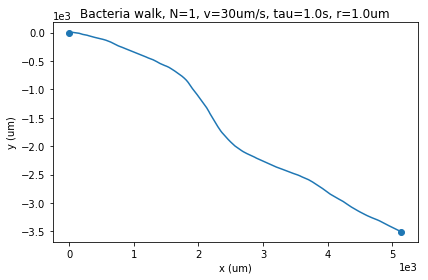

In [160]:
N = 1
v = 30.0 * 10.0**-6.0 # Rough speed of E Coli
tau = 1.0 # This should be a typical run time
rad = 1.0 * 10.0**-6.0 # This value from the problem

test = run_and_tumble(N, v, tau, rad)
test_x = 10.0**6.0 * test[0] # m -> um
test_y = 10.0**6.0 * test[1] # m -> um

plt.clf()
plt.title('Bacteria walk, N=1, v=30um/s, tau=1.0s, r=1.0um')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.scatter([test_x[0], test_x[-1]], [test_y[0], test_y[-1]])
plt.plot(test_x, test_y)
plt.show()

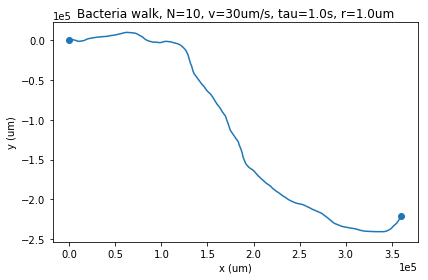

In [159]:
N = 10
v = 30.0 * 10.0**-6.0 # Rough speed of E Coli
tau = 1.0 # This should be a typical run time
rad = 1.0 * 10.0**-6.0 # This value from the problem

test = run_and_tumble(N, v, tau, rad)
test_x = 10.0**6.0 * test[0] # m -> um
test_y = 10.0**6.0 * test[1] # m -> um

plt.clf()
plt.title('Bacteria walk, N=10, v=30um/s, tau=1.0s, r=1.0um')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.scatter([test_x[0], test_x[-1]], [test_y[0], test_y[-1]])
plt.plot(test_x, test_y)
plt.show()

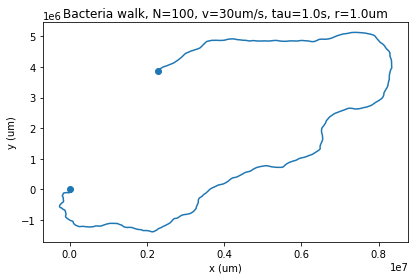

In [161]:
N = 100
v = 30.0 * 10.0**-6.0 # Rough speed of E Coli
tau = 1.0 # This should be a typical run time
rad = 1.0 * 10.0**-6.0 # This value from the problem

test = run_and_tumble(N, v, tau, rad)
test_x = 10.0**6.0 * test[0] # m -> um
test_y = 10.0**6.0 * test[1] # m -> um

plt.clf()
plt.title('Bacteria walk, N=100, v=30um/s, tau=1.0s, r=1.0um')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.scatter([test_x[0], test_x[-1]], [test_y[0], test_y[-1]])
plt.plot(test_x, test_y)
plt.show()

### For plotting D vs. tau, I'm assuming we're supposed to find D through measurement, through one of the methods in homework 3.

In [5]:
def diffusion_coefficient(dt, x, y):
    D_x = (1 / (2.0 * dt)) * (np.mean(np.diff(x)**2) + 2.0 * np.mean(np.diff(x[:-1]) * np.diff(x[1:])))
    D_y = (1 / (2.0 * dt)) * (np.mean(np.diff(y)**2) + 2.0 * np.mean(np.diff(y[:-1]) * np.diff(y[1:])))
    D = np.mean([D_x, D_y])
    return D

In [50]:
trials = 200.0
N = 1
v = 30.0 * 10.0**-6.0 # Rough speed of E Coli
#tau = 1.0 # This should be a typical run time
rad = 1.0 * 10.0**-6.0 # This value from the problem
t_step = 0.01

tau_list = np.array([0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0])
D_list = np.zeros(len(tau_list))

successes = 0.0

for trial in range(int(trials)):
    
    D_list_trial = np.zeros(len(tau_list))
    
    for ind in range(len(tau_list)):
        tau = tau_list[ind]

        test = run_and_tumble(N, v, tau, rad, t_step=t_step)
        test_x = test[0] # 10.0**6.0 * test[0] # m -> um
        test_y = test[1] # 10.0**6.0 * test[1] # m -> um

        D_list_trial[ind] = diffusion_coefficient(t_step, test_x, test_y)
    
    if not np.isnan(D_list_trial).any():
        successes = successes + 1.0
        D_list = D_list + D_list_trial
    
D_list = D_list / successes
D_list = (10.0**6.0)**2 * D_list #m^2 / s -> um^2 / s

print(successes)
print(D_list)

C:\Users\Spencer\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Spencer\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


166.0
[  4.64085949e+02   4.25789445e+03   4.64146618e+04   3.16591256e+05
   3.59032970e+06   4.87825157e+07   4.00929979e+08]


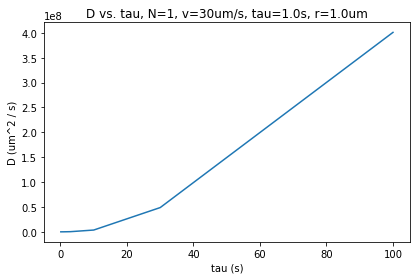

In [51]:
plt.clf()
plt.title('D vs. tau, N=1, v=30um/s, tau=1.0s, r=1.0um')
plt.xlabel('tau (s)')
plt.ylabel('D (um^2 / s)')
plt.tight_layout()
plt.plot(tau_list, D_list)

[   44.18702932   127.93841337   380.07270101   869.87225006  1584.59626873
  2070.70451225  2319.77885107]


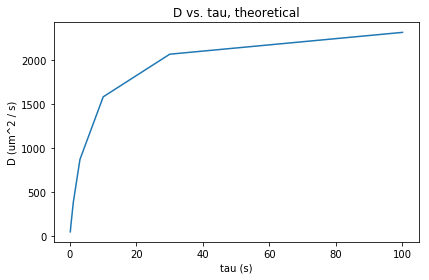

In [52]:
temp = 298.0
eta = 8.9*10.0**-4.0
k_B = 1.381 * 10.0**-23.0
D_R = k_B * temp / (8.0 * np.pi * eta * rad**3.0)

tau_eff = 1.0 / (1.0 / tau_list + 1.0 / (1.0 / D_R))
D_eff = (1.0 / 2.0) * v**2 * tau_eff
D_eff = (10.0**6.0)**2 * D_eff #m^2 / s -> um^2 / s
print(D_eff)

plt.clf()
plt.title('D vs. tau, theoretical')
plt.xlabel('tau (s)')
plt.ylabel('D (um^2 / s)')
plt.tight_layout()
plt.plot(tau_list, D_eff)

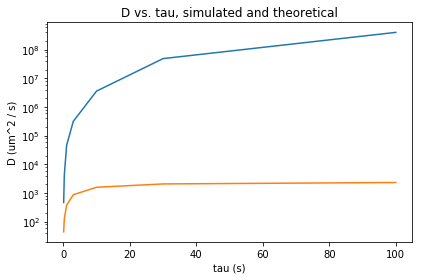

In [54]:
plt.clf()
plt.title('D vs. tau, simulated and theoretical')
plt.xlabel('tau (s)')
plt.ylabel('D (um^2 / s)')
plt.tight_layout()
plt.plot(tau_list, D_list)
plt.plot(tau_list, D_eff)
plt.yscale('log')